In the following cell we do our imports and set up our quadrature simulation model. The simulation approach here is that the model generates perfect I & Q quadrature, which we then perturb. In this case, we perturb the I channel with the imperfect_pass response, and Q is pertrubed with the add_error response. We'll plot both to make this clearer.

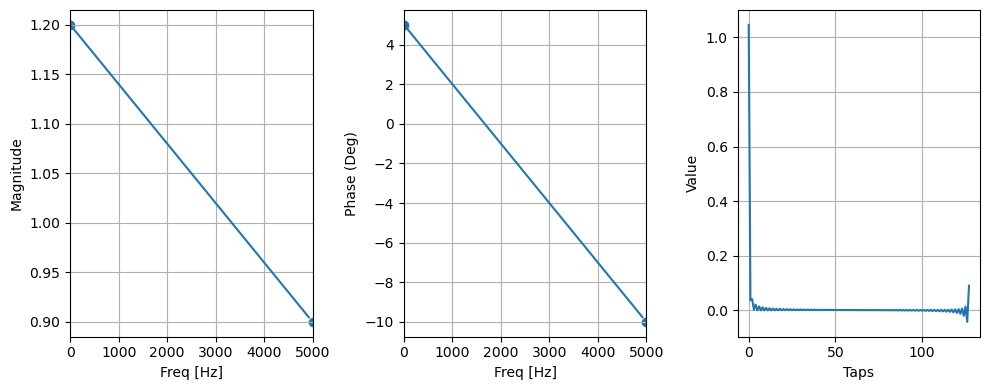

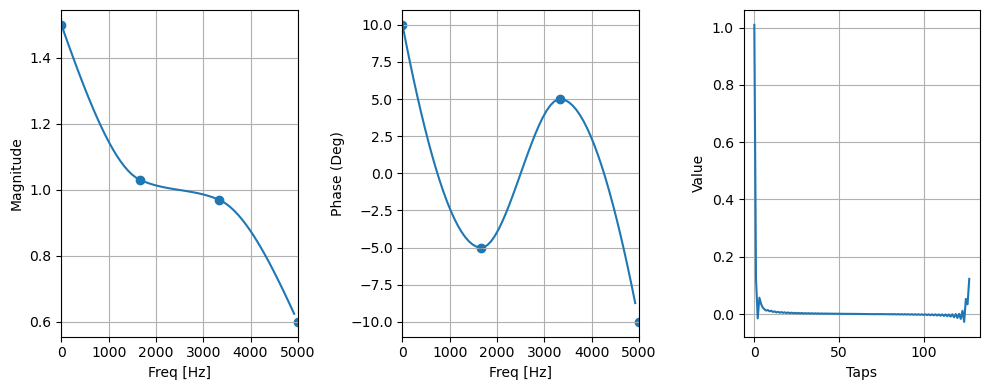

In [2]:
import utils
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import chirp

def get_chirp(fs, dur, ns):
    t = np.arange(0,dur,1/fs)
    y = chirp(t=t,f0=0,t1=t[-1],f1=fs/2) + np.random.randn(len(t))*ns
    return (t,y)

fs = 10000 #Sampling frequency
ftest = [800, 3500] #Test frequencies

chan_dict = {'I': utils.imperfect_pass(fs),
            'Q': utils.add_error(fs)
            }

quad = utils.Quadrature(fs, chan_dict)

quad.chanI.plot_resp(N=128)
quad.chanQ.plot_resp(N=128)



The top and bottom plots show the frequency response (and impulse response) of the I and Q channels respectively. Ideally, the magnitude should be 1.0 and the phase should be zero - that is, the channel response should not impose any magnitude or phase deviations onto the ideal quadrature response.

To show the effect of this, we'll inject upper and lower sideband tones at 800 Hz and 3500 Hz respectively. We're working entirely at baseband here, but this could be equivalently thought of as two tones at some carrier frequency, i.e, (fc + 800) Hz and (fc - 3500) Hz.

No existing FreqResp. Building new.
No existing FreqResp. Building new.


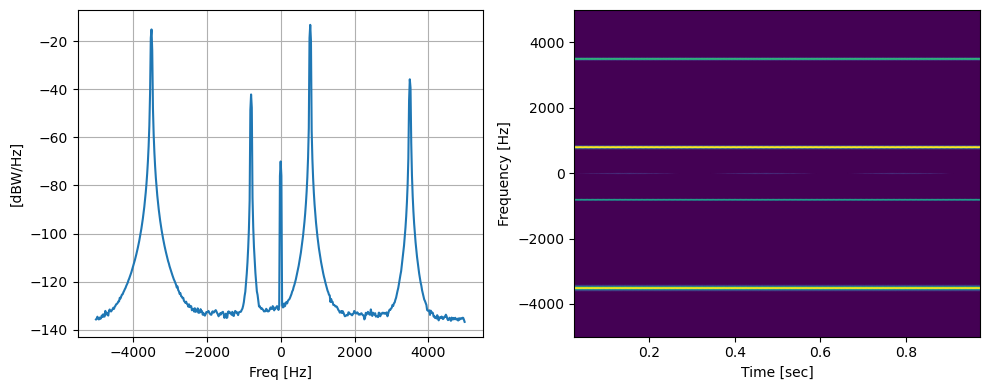

In [4]:
ns1 = 0.00001
vrng = (-20,-75) 
dur = 1

t = np.arange(0,dur,1/fs)
F = np.sin(2*np.pi*ftest[0]*t) + np.random.randn(len(t))*ns1
R = np.sin(2*np.pi*ftest[1]*t) + np.random.randn(len(t))*ns1

y1 = quad.inject_signal(F,R)
utils.quick_psd(y1,fs,plot_mode=0,vrng=vrng)

The left panel shows the time-averaged PSD and the right panel shows the spectrogram. Note the desired tone at +800 Hz has a corresponding unwanated image at -800 Hz, approximately 28 dB lower. Similarly, the desired -3500 Hz tone has an unwanted image at +3500, around 20 dB lower. These images appear due to the imperfect quadrature we imposed earlier. With perfect quadrature these images would not be present. 

It turns out we can fix this. By injecting a broadband signal and peforming system identification, it is possible to derive the necessary channel correction factor. In the following, we inject a random bipolar sequence into the upper sideband and nothing/zeros into the lower sideband. 

Supplied signal length does not match existing FreqResp. Building new.
Supplied signal length does not match existing FreqResp. Building new.


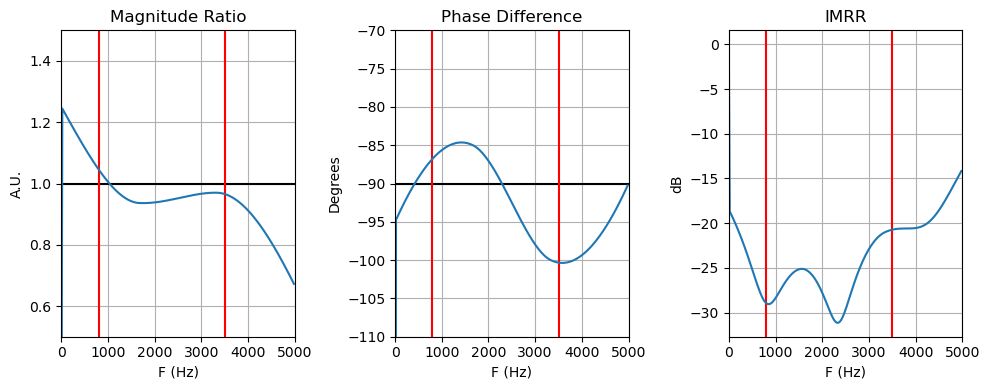

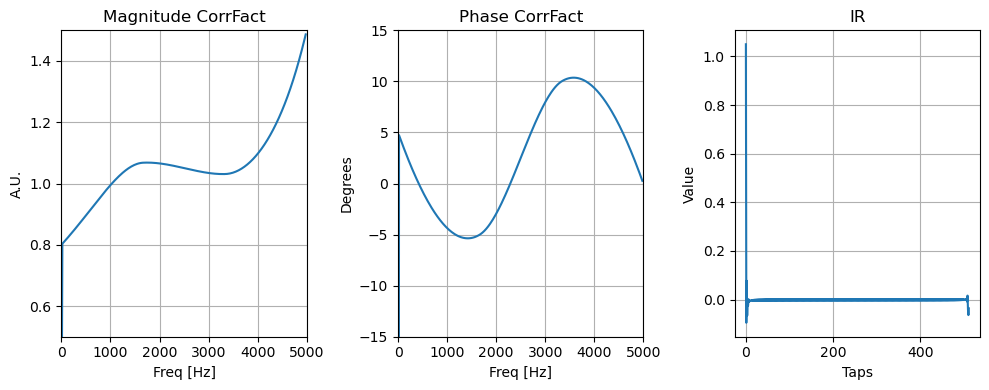

In [6]:
ns_ident = 0.0 #no noise for now - more on this later
N = 512

# Upper-sideband signal, or forward, as in 'forward-going' frequencies.
F = np.random.randint(-1,2,N).astype("float") + np.random.randn(N)*ns_ident
R = np.random.randn(N)*ns_ident #Lower-sideband signal, or 'reverse-going' frequencies

quad.sys_ident(F, R, plot=True, ftest=ftest)


The system identifcation algorithm reveals the relationship between the I and Q responses as plotted in the top panel. More precisely, it is the ratio of the two responses - the magnitude ratio and the phase difference. As a quick sanity check, the 3500 Hz tone is falling at ~ -100 deg. From the first two plots, we can compute a phase difference of -5 - 5 = -10. In other words due to our imperfect channels, we have shifted the phase from -90 to -100. The lower panel shows the correction factors needed for both magnitude and phase to recover perfect quadrature. Indeed at 3500 Hz, we find a phase correction value of +10 degrees.

An additional point of interest is the Image Rejection Ratio plot at the top right. Reading off the graph, we find values of (-)28 db and (-)21 dB for 800 and 3500 respectively, as we observed in the earlier PSD plot.

Now that we have this correction response, and its FIR represenation, lets apply it.

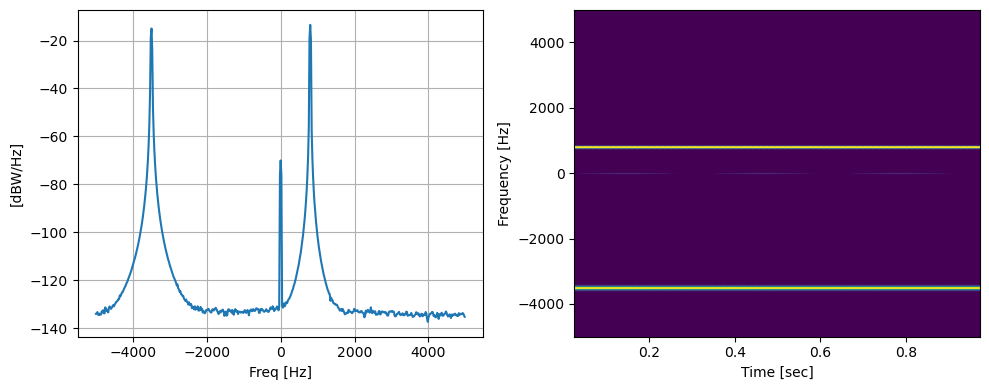

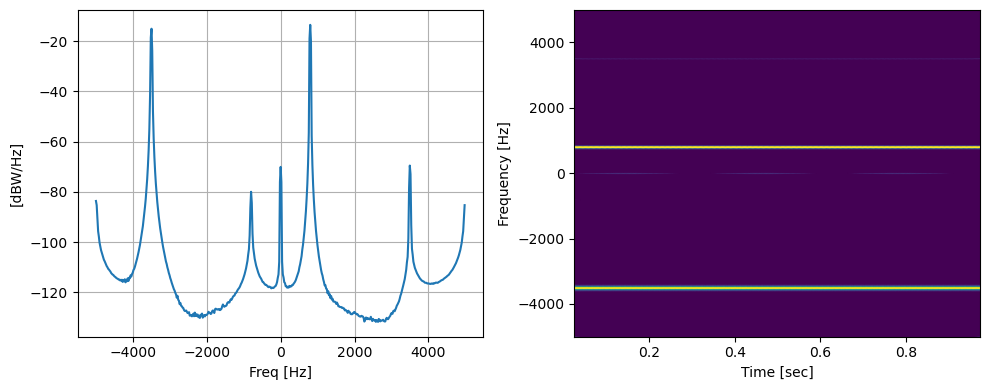

In [8]:
# Correct in frequency domain via multiplication
y1_corr_fd = quad.correct_fd(y1)
utils.quick_psd(y1_corr_fd,fs,plot_mode=0,vrng=vrng)

# Correct in time domain via convolution
y1_corr_td = quad.correct_td(y1)
utils.quick_psd(y1_corr_td,fs,plot_mode=0,vrng=vrng)


With the first block of code - frequency domain application - we have completely wiped out the mirrors! Huzza! Well, it's a nice result but unfortunately it can only be performed in an offline manner (the entire acquired signal is corrected in one go). 

The second block of code applies our corrective IR in a sliding convolution manner, which can be used in a real-time/online manner. It does not achieve perfect cancellation, but the results are still quite good, knocking down the images by an additional ~35 dB. In this case, we used 512 taps which is still quite a lot. Lets see what happens as we reduce the number of taps.

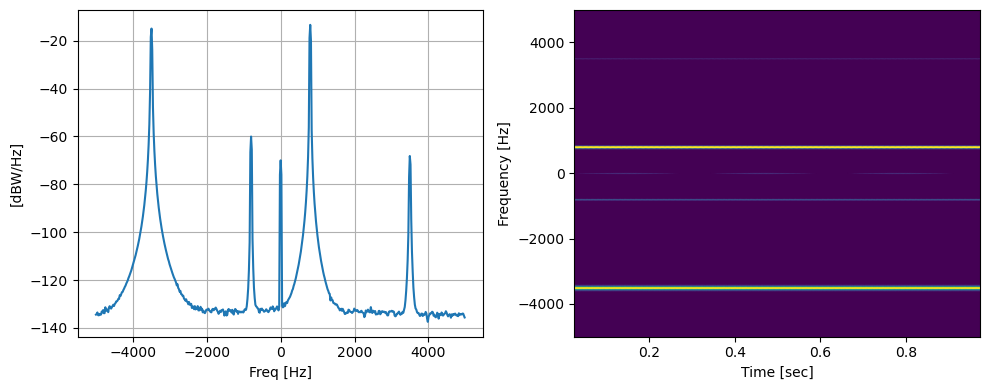

In [10]:
y1_corr_td = quad.correct_td(y1, nk=22) #Use only 64 taps
utils.quick_psd(y1_corr_td,fs,plot_mode=0,vrng=vrng)


We've reduced our FIR filter to 22 taps, and we're still knocking down the images by ~20 dB respecitvely.

Lets look at some other interesting test signals. For the next part, we'll inject a chirp signal spanning 0 to Fs/2 into the upper sideband. I used a very low noise level in the previous examples to emphasize the image cancellation, but I'll use a more reasonable level here.

Filling channel with noise
Supplied signal length does not match existing FreqResp. Building new.
Supplied signal length does not match existing FreqResp. Building new.


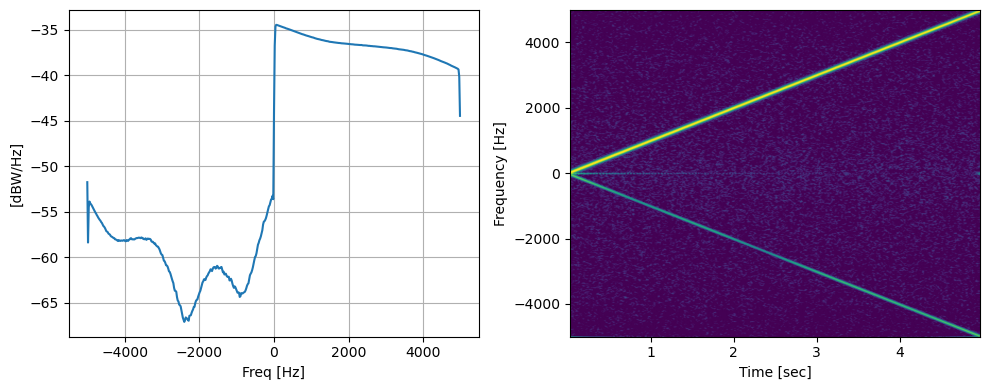

In [12]:
ns2 = 0.01
vrng = (-20,-75)    
_,F = get_chirp(fs,5,ns2)

# A difference from previous examples: by specifing a single 
# value for the reverse channel, it says to model it as a noisy channel. 
y2 = quad.inject_signal(F,ns2) 
utils.quick_psd(y2,fs,plot_mode=0,vrng=vrng)

In the spectrogram, we can see the intended sweep response injected into the USB. We can also see how our imperfect quadrature results in its image in the LSB. Observe from the PSD plot that the magnitude of the image respone matches the IMRR plot from earlier (as expected; example: at +/- 3000 Hz we observe a delta of -36-(-60) = 24 dB. The IMRR plot yields a value of ~23.5 dB). 

Lets attempt to correct it. In this block we'll stick to time-domain correcition only.

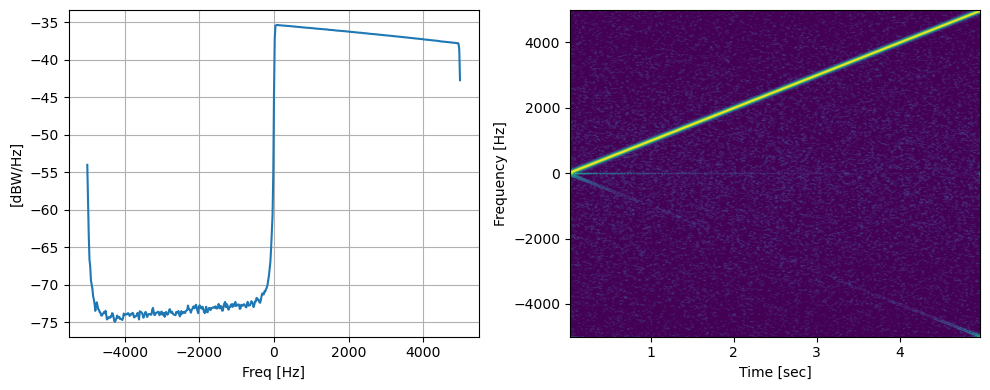

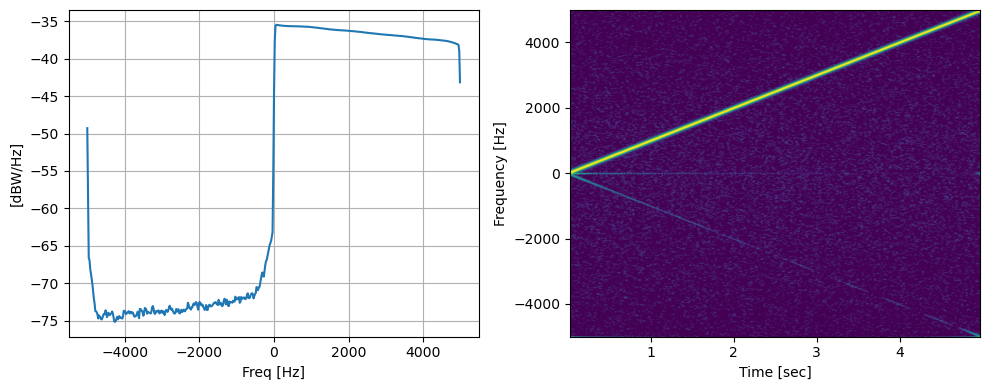

In [14]:
y2_corr = quad.correct_td(y2)
utils.quick_psd(y2_corr,fs,plot_mode=0,vrng=vrng)

# Notice that even down to only 16 taps, we still obtain quite good correctoin
utils.quick_psd( quad.correct_td(y2,nk=16) ,fs,plot_mode=0,vrng=vrng)

In both cases we've pushed the unwanted images into nearly the noise floor.

Lets do one more, just to further illustrate the point.

Supplied signal length does not match existing FreqResp. Building new.
Supplied signal length does not match existing FreqResp. Building new.


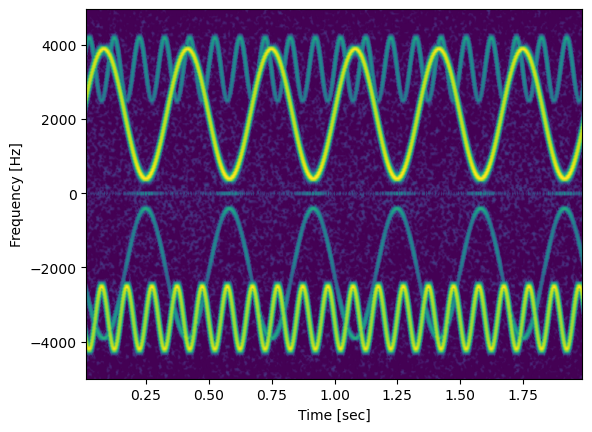

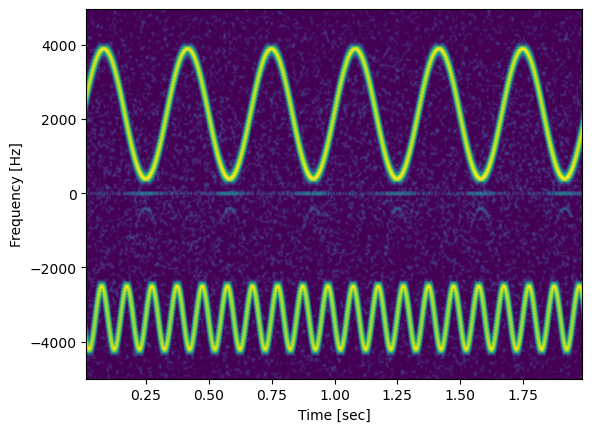

In [16]:
ns3 = 0.01
F = utils.osc_fm(fs, 2, 1, 400, 3900, 3) 
R = utils.osc_fm(fs, 2, 1, 2500, 4200, 10) 

F += np.random.randn(len(F))*ns3
R += np.random.randn(len(R))*ns3

y3 = quad.inject_signal(F,R)
utils.quick_psd(y3,fs,plot_mode=2,vrng=vrng,nperseg=256,overlap=0.90)

y3_corr = quad.correct_td(y3,nk=32)
utils.quick_psd(y3_corr,fs,plot_mode=2,vrng=vrng,nperseg=256,overlap=0.90)

Here, we have injected two different FM signals into the USB and LSB. Our imperfect quadrature system results in the top plot, where the image signals clearly interfere with each other. With our FIR correction filter applied (32 taps), the interfering images have been removed (suppressed below the noise level, to be more precise).